In [ ]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
from collections import Counter
import cv2
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import time
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
df_metadata = pd.read_csv('/content/drive/Shareddrives/IS Datathon/metadata.csv')
# split keywords into each columns
df_metadata[['kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'kw14', 'kw15',
    'kw16', 'kw17', 'kw18', 'kw19', 'kw20', 'kw21', 'kw22']] = pd.DataFrame(df_metadata['Keywords'].str.split(',', expand = True))

In [ ]:
# select needed column
df_metadata_clean = df_metadata.iloc[:, np.r_[0,5,8:30]]

In [ ]:
# flat 2d list to 1d
def flat(x):
    return [item for sublist in x for item in sublist]

In [ ]:
# select all keywords and make them into a list
list_keyword = flat(df_metadata.iloc[:, np.r_[8:30]].values)
# filter out Nan
list_keyword = list(map(lambda x: x.lower().strip(), list(filter(None, list_keyword))))
# filter out year, ex.YYYY 
list_keyword_exclude_year = list(filter((lambda x: re.match(r'^(?!\d{4})', x)), list_keyword))
# filter out keyword counts < 93 
list_keyword_greater_tuple = list(filter(lambda x: x[1] >= 93, Counter(list_keyword_exclude_year).most_common()))

In [ ]:
# drop count column and turn into list
df_keyword_greater = pd.DataFrame(list_keyword_greater_tuple, columns =['keyword', 'count']).drop('count', axis=1)
list_keyword_common = df_keyword_greater['keyword'].tolist() 
# len(list_keyword_common) = 112

In [ ]:
# split and turn into list
df_keywords = pd.DataFrame({'list_Keywords':[x.split(',') for x in df_metadata_clean['Keywords']]})
df_keywords['Record ID'] = df_metadata_clean['Record ID'].tolist()
# turn to lowercase and get unique value
df_keywords['list_Keywords_lower'] = df_keywords['list_Keywords'].map(lambda x: list(map(str.lower, x)))
# filter common keyword
df_keywords.loc[:,'list_Keywords'] = df_keywords['list_Keywords_lower'].map(lambda x: sorted(pd.unique(list(filter(lambda y: y.strip() in list_keyword_common, x))).tolist()))
# filter out []
df_keywords = df_keywords[df_keywords["list_Keywords"].str.len() != 0]

df_keywords['string_keywords'] = [','.join(map(str, l)) for l in df_keywords['list_Keywords']]
df_keyword_common = pd.DataFrame({'keyword':np.unique(df_keywords['string_keywords'].values).tolist()})

df_kw_index = df_keyword_common.reset_index()
df_kw_index = df_kw_index.rename(columns={'index': 'kw_index'})
# len(df_kw_index) = 670

# Map keyword index to keyword
df_id_index = pd.merge(df_keywords, df_kw_index, left_on=['string_keywords'], right_on = ['keyword'], how = 'left') # 9279

In [ ]:
# change keyword value to list
df_keyword_common['keyword'] = df_keyword_common.keyword.apply(lambda x: x.split(','))

## Read image

Read image and save in numpy array

In [ ]:
import gdown

file_id = '1O_DHJIFFvWKDpl_Mkv793v5GhMgjrERm'
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}",
)
!unzip images-20220415T152945Z-001

In [ ]:
#Add RecordID_jpg column to connect data to jpg file
df_id_index['RecordID_jpg'] = df_id_index['Record ID'].astype("string") + '.jpg'

In [ ]:
def readfile(workspace_dir, label):
    image_dir = sorted(os.listdir(workspace_dir))
    #Change image to the same size 128 * 128
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=int)
    not_exist = []
    for i, file in enumerate(image_dir):    
      try:
        img = cv2.imread(os.path.join(workspace_dir, file))
        #filter broken image
        if not re.search("-", file) and re.search("jpg", file) and (sum(df_id_index['RecordID_jpg'] == file) == 1):   
          x[i, :, :] = cv2.resize(img,(128, 128))
          if label:
              y_col = df_id_index.loc[df_id_index['RecordID_jpg'] == file]
              # if (y_col.iloc[0]['kw_index'] != y_col.iloc[0]['kw_index']) == False:
              y[i] = y_col.iloc[0]['kw_index'].astype(int)
        else:
            not_exist.append(i)      
      except Exception as e:
        print(file)
    x = np.delete(x,not_exist, axis = 0)
    y = np.delete(y,not_exist, axis = 0)
    if label:
      return x, y
    else:
      return x

In [ ]:
workspace_dir = '/content/drive/Shareddrives/IS Datathon/images/'
data_x, data_y = readfile(workspace_dir, True)

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2,random_state=42)

## Dataset

In [ ]:
# trainging - data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15), 
    transforms.ToTensor(), 
])
# testing 
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None: 
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [ ]:
# save in dataloader
batch_size = 32
train_set = ImgDataset(train_x, train_y, train_transform) 
# train_set.__len__() = 7112
val_set = ImgDataset(val_x, val_y, test_transform)  
# val_set.__len__() = 1779
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)

Model

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d( 
                in_channels = 3,     # in_channels
                out_channels = 256,  # out_channels
                kernel_size = 3,     # filter size
                stride = 1,          # filter movement/step
                padding = 1),        # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 2, 
                stride = 2,  
                padding = 0),      # [256, 64, 64]   

            nn.Conv2d(256, 256, 3, 1, 1), # [256, 64, 64]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 32, 32]

            nn.Conv2d(256, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 256, 3, 1, 1), # [256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 8, 8]

            nn.Conv2d(256, 256, 3, 1, 1), # [256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 8, 8]
            
        )
        self.fc = nn.Sequential(
            nn.Linear(256*4*4, 2048),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(2048, 670),
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)
        output = self.fc(x)
        return output

Training

In [ ]:
tr_acc = []
va_acc = []
tr_loss = []
va_loss = []
running_train_recall = []
running_val_recall = []
epoch_num = []
# torch.manual_seed(20742)
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # CrossEntropyLoss for classification task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 75

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_recall = []
    train_loss = 0.0
    val_acc = 0.0
    val_recall = []
    val_loss = 0.0

    model.train() # training
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # set the gradients of all optimized torch.Tensor to zero
        train_pred = model(data[0].cuda()) # get prediction
        batch_loss = loss(train_pred, data[1].cuda()) # compute loss
        batch_loss.backward() # back propagation compute gradient
        optimizer.step() # optimizer use gradients to update parameters

        for l in range(len(data[1].numpy())):
          x_index = np.argmax(train_pred.cpu().data.numpy(), axis=1)[l]
          x = df_keyword_common.iloc[x_index]['keyword']
          y_index = data[1].numpy()[l]
          y = df_keyword_common.iloc[y_index]['keyword']
          # compute accuracy
          train_acc += len(set(x).intersection(set(y)))/len(set(x).union(set(y)))
          train_recall.append(len(set(x).intersection(set(y)))/len(x))

        train_loss += batch_loss.item()

    model.eval() # testing
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            for l in range(len(data[1].numpy())):
              x_index = np.argmax(val_pred.cpu().data.numpy(), axis=1)[l]
              x = df_keyword_common.iloc[x_index]['keyword']
              y_index = data[1].numpy()[l]
              y = df_keyword_common.iloc[y_index]['keyword']
              val_acc += len(set(x).intersection(set(y)))/len(set(x).union(set(y)))
              val_recall.append(len(set(x).intersection(set(y)))/len(x))

            val_loss += batch_loss.item()

        # print result
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
            train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        
        tr_acc.append(train_acc/train_set.__len__())
        va_acc.append(val_acc/val_set.__len__())
        tr_loss.append(train_loss/train_set.__len__())
        va_loss.append(val_loss/val_set.__len__())
        running_train_recall.append(np.asarray(train_recall).mean())
        running_val_recall.append(np.asarray(val_recall).mean())
        epoch_num.append(epoch)

In [ ]:
#save model parameters
model_save_name = 'classifier_4layer_0001.pt'
model_path = F"/content/drive/Shareddrives/IS Datathon/{model_save_name}"
torch.save(model.state_dict(), model_path)

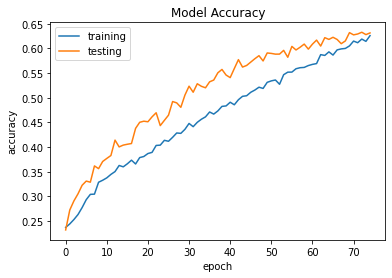

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(epoch_num, tr_acc, label = "training")
plt.plot(epoch_num, va_acc, label = "testing")
 
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model Accuracy')
fig.patch.set_facecolor('white')
plt.legend()
plt.show()

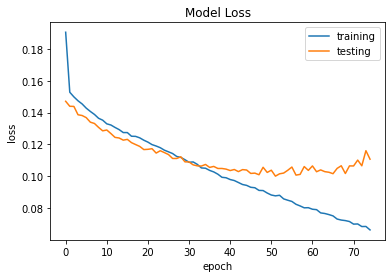

In [ ]:
plt.plot(epoch_num, tr_loss, label = "training")
plt.plot(epoch_num, va_loss, label = "testing")
 
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model Loss')
fig.patch.set_facecolor('white')
plt.legend()
plt.show()

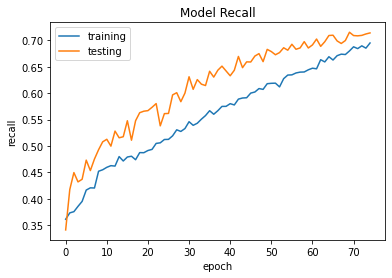

In [ ]:
plt.plot(epoch_num, running_train_recall, label = "training")
plt.plot(epoch_num, running_val_recall, label = "testing")
 
plt.xlabel('epoch')
plt.ylabel('recall')
plt.title('Model Recall')
fig.patch.set_facecolor('white')
plt.legend()
plt.show()

# Prediction

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import re
from torch.utils.data import DataLoader, Dataset
import csv 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# testing
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None: 
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d( 
                in_channels = 3,     # in_channels
                out_channels = 256,  # out_channels
                kernel_size = 3,     # filter size
                stride = 1,          # filter movement/step
                padding = 1),        # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 2, 
                stride = 2,  
                padding = 0),      # [256, 64, 64]   

            nn.Conv2d(256, 256, 3, 1, 1), # [256, 64, 64]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 32, 32]

            nn.Conv2d(256, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 256, 3, 1, 1), # [256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 8, 8]

            nn.Conv2d(256, 256, 3, 1, 1), # [256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 8, 8]
        )
        self.fc = nn.Sequential(
            nn.Linear(256*4*4, 2048),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(2048, 670),
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)
        output = self.fc(x)
        return output

In [ ]:
def get_img(path, image_list):
  x = np.zeros((len(image_list), 128, 128, 3), dtype=np.uint8)
  file_name = []
  not_exist = []
  for i, file in enumerate(image_list):
    try:
      img = cv2.imread(os.path.join(path, file))
      if not re.search("-", file) and re.search("jpg", file):
        x[i, :, :] = cv2.resize(img,(128, 128))
        file_name.append(file.split(".")[0])
      else:
        not_exist.append(i)    
    except Exception as e:
      print(file)
  x = np.delete(x,not_exist, axis = 0)    
  return x, file_name

In [ ]:
path = '/content/drive/Shareddrives/IS Datathon/images/'
import random
random.seed(20742)
image_list = sorted(os.listdir(path))
random.shuffle(image_list)
image_list = image_list[:round(len(image_list)*0.2)]
# image_list = ['test.jpg']

test_x, file_name = get_img(path, image_list)
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

model_test = Classifier()
model_name = 'classifier_5layer_0001_final.pt'
model_path = F"/content/drive/Shareddrives/IS Datathon/{model_name}"
model_test.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_test.eval()

df_keyword_common = pd.read_csv('/content/drive/Shareddrives/IS Datathon/test_captions_list.csv')
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_test(data)
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            y_keyword = df_keyword_common.iloc[y]['keyword']
            prediction.append(y_keyword)

In [ ]:
# output train.tsv
df_id_index = df_id_index.iloc[:, np.r_[0,1]]
cols = list(df_id_index)
a, b = cols.index('list_Keywords'), cols.index('Record ID')
cols[b], cols[a] = cols[a], cols[b]
df_train = df_id_index[cols]

path = '/content/drive/Shareddrives/IS Datathon/train.tsv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_train.to_csv(f, sep="\t", index = False)

In [ ]:
# output test.tsv
df_test = pd.DataFrame(file_name, columns =['Record ID'])

path = '/content/drive/Shareddrives/IS Datathon/test.tsv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_test.to_csv(f, sep="\t", index = False)

In [ ]:
# output test_captions_list.csv
path = '/content/drive/Shareddrives/IS Datathon/test_captions_list.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_keyword_common.to_csv(f, index = False)

In [ ]:
# output sample_submission.csv
df_sample_submission = pd.DataFrame(list(zip(file_name,prediction)), columns =['Record ID', 'Prediction']) 

path = '/content/drive/Shareddrives/IS Datathon/sample_submission.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_sample_submission.to_csv(f, index = False)